# Demo for the Supramolecular Copolymerization Benchmark

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from phaseGP.models import PhaseGP, PhaseTransferGP
from phaseGP.utils import brute_sample_new_points, get_grid, set_seeds
from phaseGP.visualization import model_diagram_plot, phase_diagram_plot, phase_diagram_probability_plot, phase_acquisition_plot

from ground_truth.true_phase import true_phase

In [2]:
#Equilibrium Target fAA = 0.01 fAB = 5 , Source = [fAA = 0.01, fAB = 0.5], [fAA = 0.1, fAB = 5]
sources = ["equilibrium_fracAA0.01_fracAB0.5", "equilibrium_fracAA0.1_fracAB5"]
title_names = [r"$f_{AA} = 0.01, f_{AB} = 0.5$",r"$f_{AA} = 0.1, f_{AB} = 5$" ]
benchmark_name = "equilibrium_fracAA0.01_fracAB5"
title_name = r"$f_{AA} = 0.01, f_{AB} = 5$"
set_seeds(0)

# Source Tasks

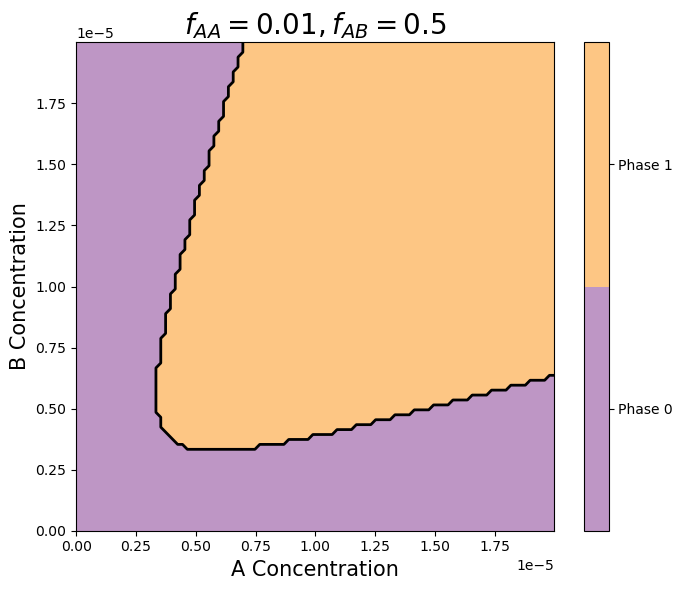

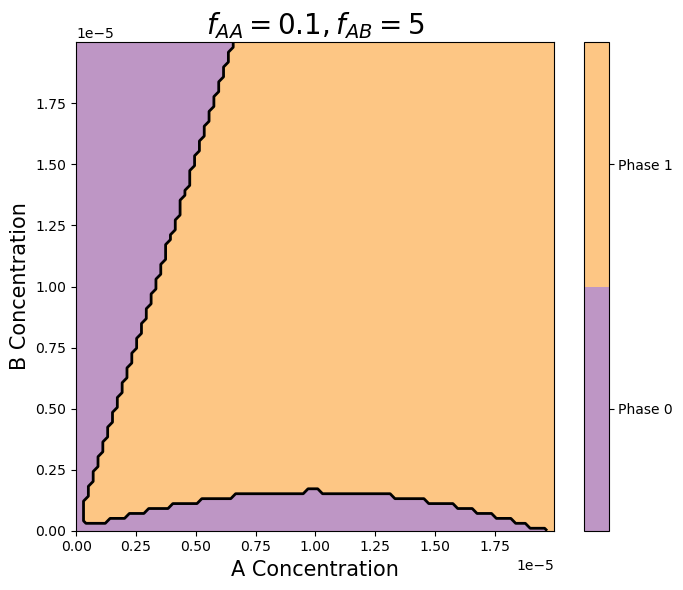

In [3]:
grid_points, x1, x2 = get_grid(x_min=0, x_max=2e-5, grid_size=100, return_coordinates=True)

for source, title in zip(sources, title_names):
    phase_diagram = true_phase(grid_points, benchmark_name=source).reshape(100,100).T
    phase_diagram_plot(phase_diagram, x1, x2, plot_boundary=True, 
                       xlabel="A Concentration", ylabel="B Concentration", title=title)

# Target Task

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': '$f_{AA} = 0.01, f_{AB} = 5$'}, xlabel='A Concentration', ylabel='B Concentration'>)

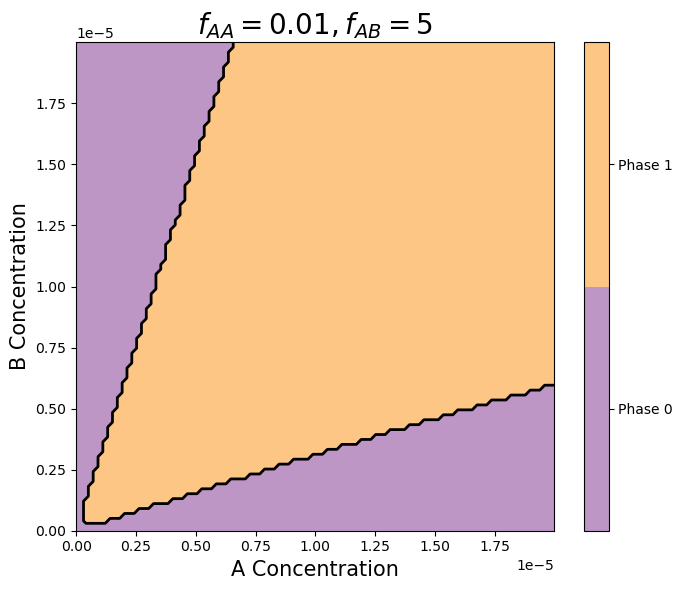

In [4]:
grid_points, x1, x2 = get_grid(x_min=0, x_max=2e-5, grid_size=100, return_coordinates=True)

phase_diagram = true_phase(grid_points, benchmark_name=benchmark_name).reshape(100,100).T
phase_diagram_plot(phase_diagram, x1, x2, plot_boundary=True, 
                       xlabel="A Concentration", ylabel="B Concentration", title=title_name)

# Run Active learning on source tasks

In [5]:
def source_active_learning_loop(benchmark_name, max_scale = 2e-5,n_points=50, n_initial_points = 5, candidate_size = 20, test_size = 100):
    train_x = torch.rand(n_initial_points, 2)*max_scale
    train_y = true_phase(train_x, benchmark_name=benchmark_name )

    candidate_grid = get_grid(0,max_scale, candidate_size)
    test_grid = get_grid(0,max_scale, test_size)
    test_y = true_phase(test_grid, benchmark_name=benchmark_name )

    error_curve = []
    train_x = train_x
    train_y = train_y
    test_grid = test_grid
    for i in tqdm(range(n_points)):
        model = PhaseGP(train_x, min_scale=0, max_scale=max_scale)
        model.fit(train_x, train_y)

        new_point, new_index_list = brute_sample_new_points(model, candidate_grid, train_x, return_index=True)
        mask = torch.ones(len(candidate_grid), dtype=torch.bool)
        mask[new_index_list] = False
        candidate_grid = candidate_grid[mask]

        new_point_y = true_phase(new_point, benchmark_name=benchmark_name)
        train_x = torch.cat([train_x, new_point], dim=0)
        train_y = torch.cat([train_y, new_point_y], dim=0)

        pred_points = model.predict(test_grid)
        corect_predictions = pred_points != test_y
        error = torch.mean(corect_predictions.float())
        error_curve.append(error)
    return model, error_curve, train_x

In [6]:
source_model_list = []

for source_benchmark_name in sources:
    model, _, _ = source_active_learning_loop(source_benchmark_name)
    source_model_list.append(model)

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


# Run Active Learning on Vanilla GP Implementation

In [7]:
vanilla_model, vanilla_error_curve, vanilla_sampled_points = source_active_learning_loop(benchmark_name)

100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


# Run Active Learning on TL Model 

In [8]:
def tl_active_learning_loop(source_model_list, benchmark_name, max_scale = 2e-5, n_points=50, n_initial_points = 5, candidate_size = 20,
                             test_size = 100, prior_aggregation="linear"):
    train_x = torch.rand(n_initial_points, 2)*max_scale
    train_y = true_phase(train_x, benchmark_name=benchmark_name )

    candidate_grid = get_grid(0,max_scale, candidate_size)
    test_grid = get_grid(0,max_scale, test_size)
    test_y = true_phase(test_grid, benchmark_name=benchmark_name )

    error_curve = []
    train_x = train_x
    train_y = train_y
    test_grid = test_grid

    for i in tqdm(range(n_points)):
        model = PhaseTransferGP(source_model_list, train_x, min_scale=0, max_scale=max_scale, prior_aggregation=prior_aggregation)
        model.fit(train_x, train_y)

        new_point, new_index_list = brute_sample_new_points(model, candidate_grid, train_x, return_index=True)
        mask = torch.ones(len(candidate_grid), dtype=torch.bool)
        mask[new_index_list] = False
        candidate_grid = candidate_grid[mask]

        new_point_y = true_phase(new_point, benchmark_name=benchmark_name)
        train_x = torch.cat([train_x, new_point], dim=0)
        train_y = torch.cat([train_y, new_point_y], dim=0)

        pred_points = model.predict(test_grid)

        corect_predictions = pred_points != test_y
        error = torch.mean(corect_predictions.float())
        error_curve.append(error)
    return model, error_curve, train_x

### Single Source PhaseTransfer

In [9]:
tl_single_model, tl_single_error_curve, tl_single_sampled_points = tl_active_learning_loop([source_model_list[0]], benchmark_name)

100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


### Multi Source PhaseTransfer (Best performing model in general)

In [10]:
multi_tl_model, multi_tl_error_curve, multi_tl_sampled_points = tl_active_learning_loop(source_model_list, benchmark_name, prior_aggregation="linear")

100%|██████████| 50/50 [02:12<00:00,  2.64s/it]


# Phase Diagram Results

In [11]:
def draw_boundary(ax, color="k"):
    grid_points, x1, x2 = get_grid(x_min=0, x_max=2e-5, grid_size=500, return_coordinates=True)


    phase_diagram = true_phase(grid_points, benchmark_name=benchmark_name).reshape(500,500)
    levels = [-0.5, 0.5, 1.5]

    contours = ax.contour(x1, x2, phase_diagram, levels=levels, linestyles='dashed',
                colors=color, linewidths=1.5, alpha=1)
    
    line = plt.Line2D([0], [0], color=color, linewidth=2.5, label='True Boundary', linestyle="--")
    
    return ax, line

def draw_diagram_and_boundary(model, points=None, plot_type="phase", n_initial_points = 5 ,plot_boundary = False, figsize=(7,6), title=None,
                               xlabel=r"$a_{tot}$ concentration ($\mu$M)", ylabel=r"$a_{tot}$ concentration ($\mu$M)",
                                 phase_labels = ["Monomer\nPolymerization\n< 50%", "Monomer\nPolymerization\n> 50%"]):
    fig, ax = model_diagram_plot(model, plot_type=plot_type, x_min =0, x_max = 2e-5,phase_labels=phase_labels,
                                 sampled_points=points, plot_boundary=plot_boundary, figsize=figsize, title=title,
                                 xlabel=xlabel,ylabel=ylabel)


    if(plot_type != "acquisition"):
        #True Boundary in black
        ax, boundary_line = draw_boundary(ax, color="k")
        if(plot_type=="phase"):
            ax.scatter(points[:n_initial_points,1], points[:n_initial_points,0], c='blue', s=50, marker='o', label='Initial points')
            ax.scatter(points[n_initial_points:,1], points[n_initial_points:,0], c='red', s=80, marker='x', label='Sampled points')
            legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                      markersize=8, label='Initial points'),
            plt.Line2D([0], [0], marker='x', color='red', linewidth=0,
                      markersize=10, label='Sampled points'),
            boundary_line  # This is the proxy line for the contour
            ]
        
            ax.legend(handles=legend_elements, fontsize=15, loc="upper right")
    else:
        #True Boundary in white
        ax, boundary_line = draw_boundary(ax, color="w")
        plt.legend(fontsize=15)

    colorbar_ax = fig.axes[-1]
    colorbar_ax.tick_params(labelsize=15)  # For ticks
    colorbar_ax.set_ylabel(colorbar_ax.get_ylabel(), fontsize=15)
    plt.tight_layout()

### Plot the phase diagram

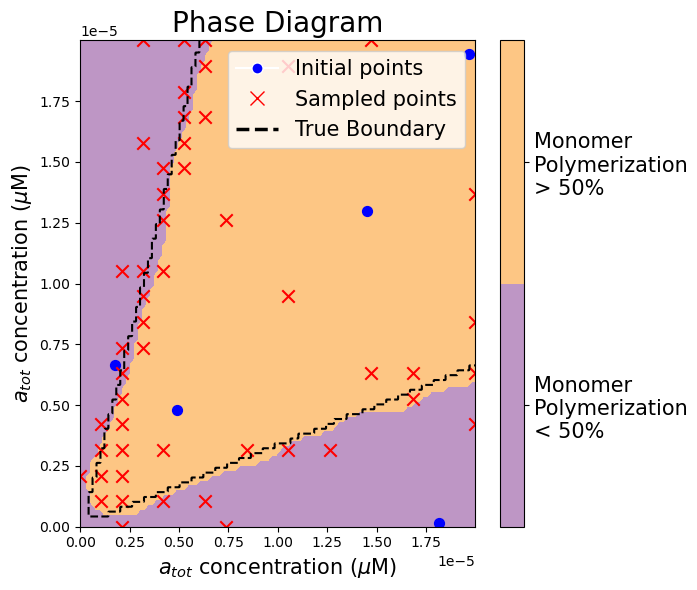

In [12]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="phase")

### Plot the Probability diagram

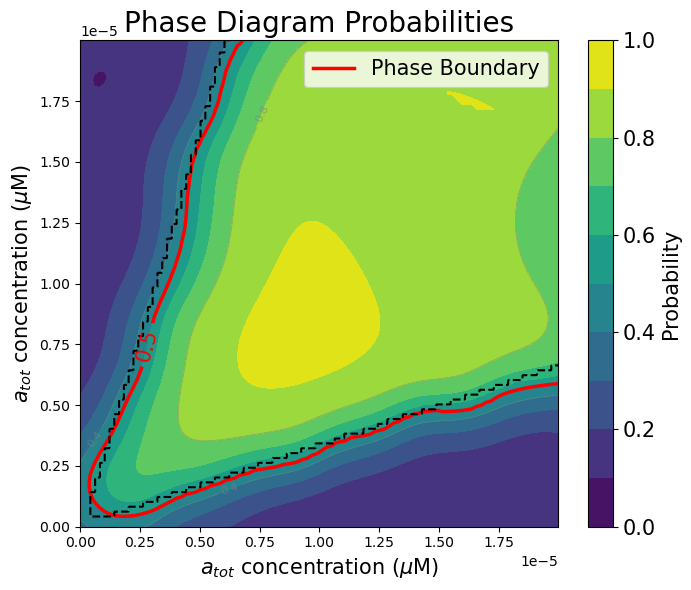

In [13]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="probability", plot_boundary=True)

### Plot the Acquisition values

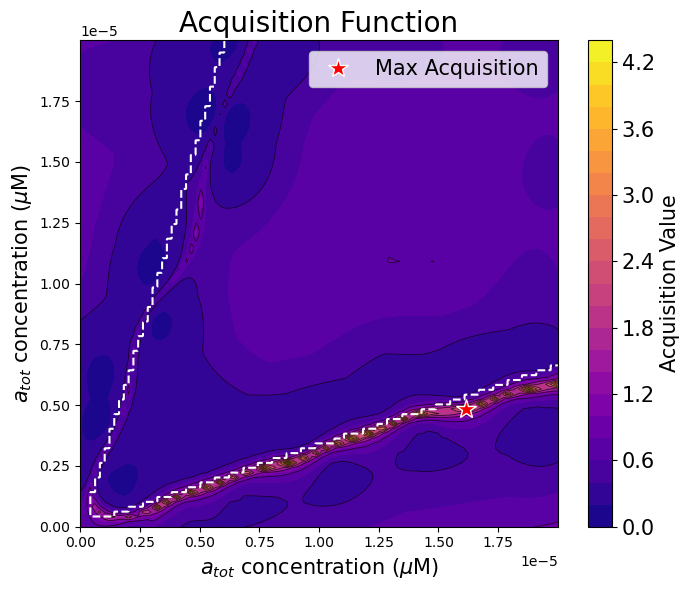

In [14]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="acquisition")

### Plot the weights

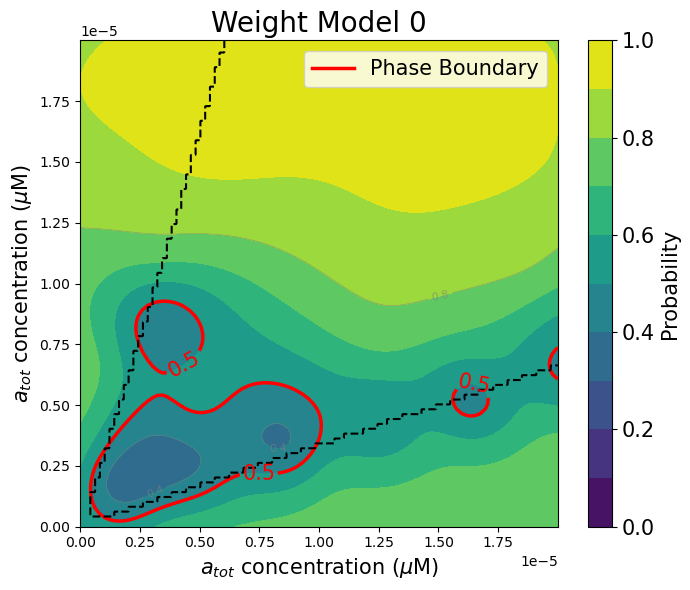

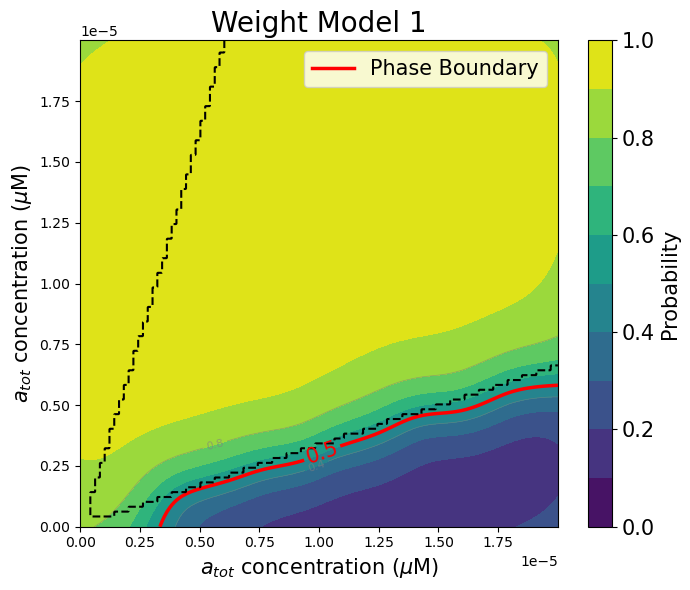

In [15]:
for i, weight_model in enumerate(multi_tl_model.weight_model_list):
    draw_diagram_and_boundary(weight_model, figsize = (7,6), plot_type="probability", plot_boundary=True, title=f"Weight Model {i}")

# Error Curves Results

Vanilla acc: 0.02669999934732914
First under 0.1 error: 9
First under 0.05 error: 25
----------------------
Single Source
PhaseTransfer acc: 0.036400001496076584
First under 0.1 error: 10
First under 0.05 error: 41
----------------------
Multi Source
PhaseTransfer acc: 0.016899999231100082
First under 0.1 error: 1
First under 0.05 error: 19
----------------------
----------------------


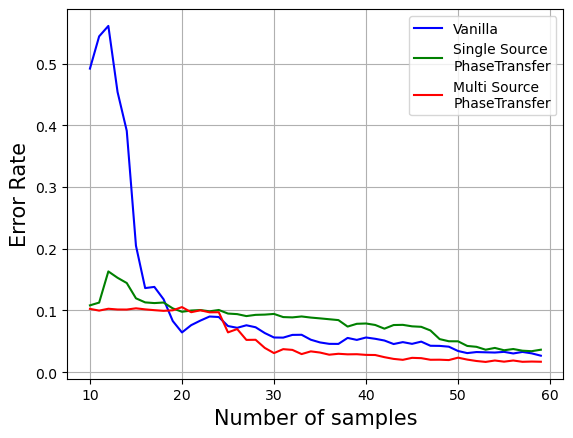

In [16]:

acc_threshold = 0.05


label = ["Vanilla", "Single Source\nPhaseTransfer", "Multi Source\nPhaseTransfer"]
color = ["blue", "green", "red", "aqua"]
error_curves = [np.array(vanilla_error_curve), np.array(tl_single_error_curve), np.array(multi_tl_error_curve)]
points = np.arange(len(vanilla_error_curve))

for i, error_curve in enumerate(error_curves):
    plt.plot(points+10, error_curve, label=label[i], color=color[i])
    plt.legend(fontsize = 10)

    first_index = np.argmax(error_curve < acc_threshold*2) if np.any(error_curve< acc_threshold*2) else -1
    print(f"{label[i]} acc: {error_curve[-1]}")
    print(f"First under {acc_threshold*2} error: {first_index}")
    first_index = np.argmax(error_curve < acc_threshold) if np.any(error_curve < acc_threshold) else -1
    print(f"First under {acc_threshold} error: {first_index}")
    print("----------------------")

print("----------------------")
plt.xlabel("Number of samples", fontsize=15)
plt.ylabel("Error Rate", fontsize=15)
plt.grid()
plt.show()
  